# Visualization with Polarplot

Example of how to use Polarplot to visualize data (Figure 5 in paper). Polarplot is useful for showing data in a polar coordinate system, and takes coordinates in magnetic latitude and magnetic local time (MLT). Other polar coordinate systems can be used, for instance geographic coordinates (although the geographoc logitude must be converted to fractions of 24 hours - easily done by division by 15).

In this notebook we will:
- Set up a local cubed sphere (CS) grid.
- Initiate Polarplot objects (axes) as well as two Cartesian axes for plotting in grid coordinates $\xi, \eta$.
- Plot coastlines on a Polarplot axis and a grid axis.
- Plot grid and outline of the grid on the axes.
- 

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import apexpy
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

Re = 6371.2e3                         # Earth's radius
HI = 110e3                            # Ionospheric altitude
time = dt.datetime(2005, 9, 10, 0, 0) # time for map and coordinate conversion
B0 = 3.12e-5                          # Mean magnetic field

# TODO: update this when polplot is included in Lompe
from polplot import Polarplot

#### Set up the cubed sphere grid
We make a cubed sphere grid centered at 88$^{\circ}$W and 72$^{\circ}$N. The grid covers a 5000 km$\times$5000 km area and is rotated 45$^{\circ}$ (towards the north). For illustration purposes, the grid is quite coarse, with a resolution of 200 km$\times$200 km.

In [2]:
L, W, Lres, Wres = 7000e3, 5000e3, 200e3, 200e3 # m
position = (-88, 72)                            # geographic lon, lat of center of grid
orientation = 45                                # angle defining orientation of xi-axis (towards north)
projection = lompe.cs.CSprojection(position, orientation)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set grid to ionospheric altitude

#### Set up figure, polar axes and coastlines

We then set up a figure with panels (A) and (C) having Polarplot axes. We set the lower limit to 50$^{\circ}$ magnetic latitude, and give coordinates in the default magnetic latitude, local time (MLT). Panels (B) and (D) will show the same thing as the Polarplots but in grid coordinates. A built in method for plotting coastlines on the Polarplots make it easy to get a map on the axis. It is also straight forward to plot the coastlines on the grid axis through a class method that gets coastlines projected to the grid coordinates.

The map will move beneath the Polarplot axis during the day as the Earth rotates, and a datetime is required by the coastline method.

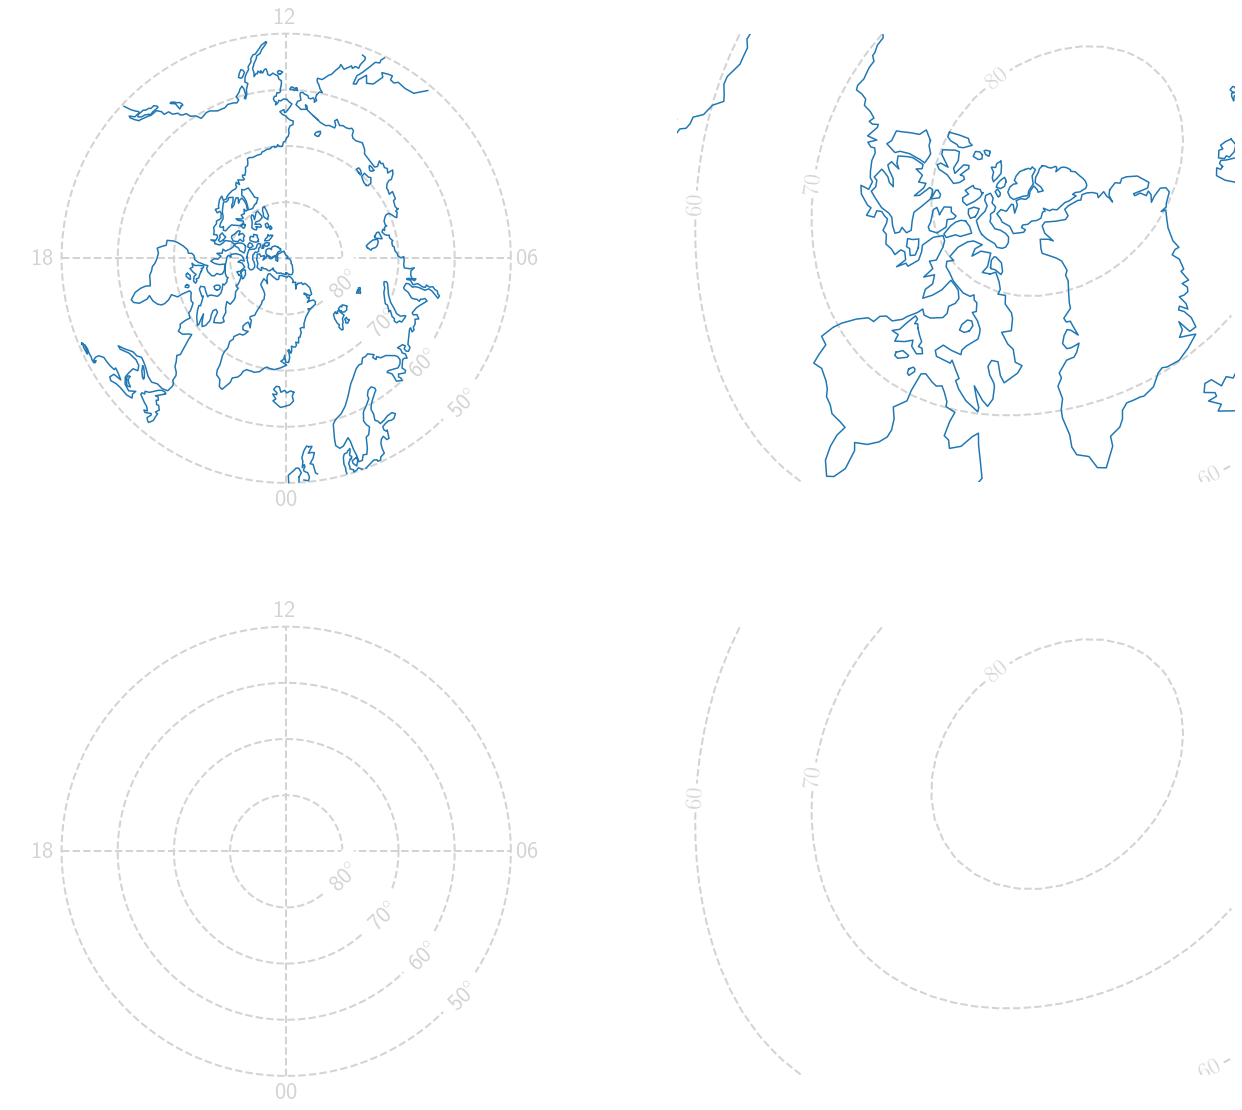

In [3]:
# set up figure and subplots
fig = plt.figure(figsize = (22,20))
axs = {}

axs['grid'  ] = fig.add_subplot(222)
axs['grid2' ] = fig.add_subplot(224)
axs['polar' ] = fig.add_subplot(221)
axs['polar2'] = fig.add_subplot(223)

# remove borders from axes and set aspect ratio
for key in axs.keys():
    axs[key].set_axis_off()
    axs[key].set_aspect('equal')

# polar axes with MLAT/MLT labels
pax  = Polarplot(axs['polar' ], minlat=50, plotgrid=True, linewidth=2)
pax2 = Polarplot(axs['polar2'], minlat=50, plotgrid=True, linewidth=2)
textargs = {'fontsize':24, 'color':'lightgrey'}
pax. writeMLTlabels( mlat=49, **textargs)
pax2.writeMLTlabels( mlat=49, **textargs)
pax. writeMLATlabels( mlt=3 , **textargs)
pax2.writeMLATlabels( mlt=3 , **textargs)

# magnetic latitude contours on grid axes
apex = apexpy.Apex(time, refh=HI*1e-3)            # to MLAT/MLT (HI is grid altitude)
mlat, _ = apex.geo2apex(grid.lat_mesh, grid.lon_mesh, height = HI*1e-3)
latlevels = np.r_[-80:81:10]
co  = axs['grid' ].contour(grid.xi_mesh, grid.eta_mesh, mlat, linestyles = '--', colors='lightgrey', linewidths=2, levels=latlevels)
co2 = axs['grid2'].contour(grid.xi_mesh, grid.eta_mesh, mlat, linestyles = '--', colors='lightgrey', linewidths=2, levels=latlevels)
axs['grid' ].clabel(co,  co.levels, inline = True, fontsize=textargs['fontsize'])
axs['grid2'].clabel(co2, co.levels, inline = True, fontsize=textargs['fontsize'])

# adjust limits of grid axes
xlim, ylim = (grid.xi_mesh[0, 0], grid.xi_mesh [-1, -1]+.005), (grid.eta_mesh [0, 0], grid.eta_mesh[-1, -1])
axs['grid' ].set_xlim(xlim)
axs['grid' ].set_ylim(ylim)
axs['grid2'].set_xlim(xlim)
axs['grid2'].set_ylim(ylim)

# coastlines on polar axis
map_kwargs = {'resolution':'110m', 'category':'physical', 'name':'coastline'}
plot_kwargs = {'color':'C0', 'zorder':2}
pax.coastlines(time, map_kwargs=map_kwargs, plot_kwargs=plot_kwargs)

# coastlines on grid axis
for cl in grid.projection.get_projected_coastlines(**map_kwargs):
    axs['grid' ].plot(cl[0], cl[1], **plot_kwargs)
    

#### Plot

We wan use standard "plot" methods to show the grid on the Polarplot axes. Note that the Polarplot methods are very similar to the corresponding built-in matplotlib.pyplot methods which are used to visualize on the Cartesian CS grid axes. Plotting arguments that work for the pyplot equivalent can be passed to the Polarplot object (color, linewidth, zorder, etc.).

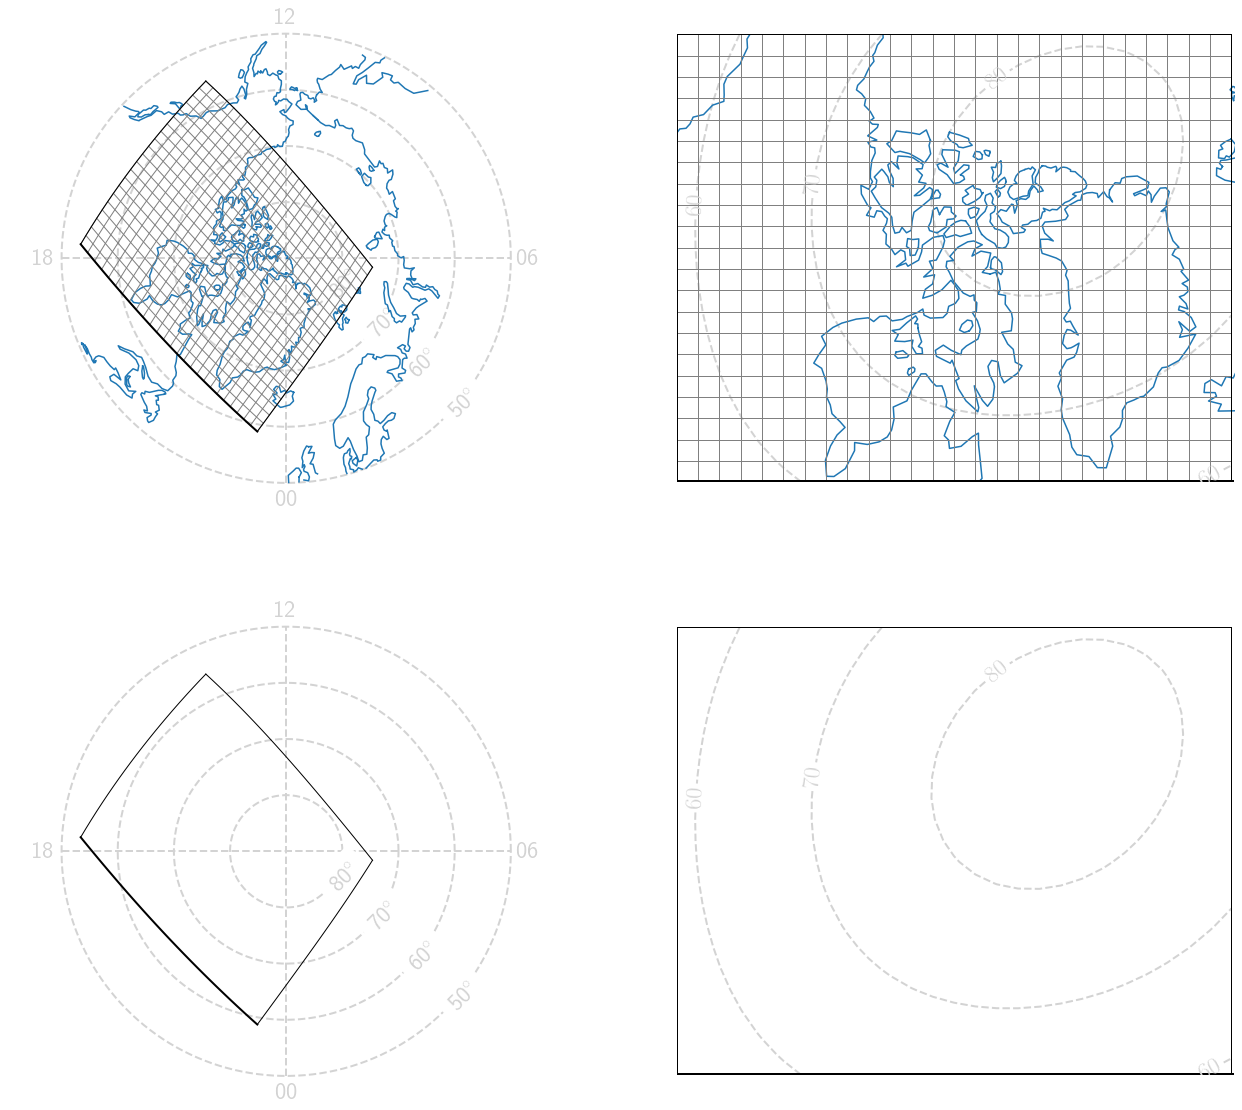

In [4]:
plotargs = {'color':'grey', 'lw':1}
# grid cells on polar axis
for lon, lat in grid.get_grid_boundaries():
    mlat, mlon = apex.geo2apex(lat, lon, HI*1e-3) # to MLAT/MLT
    mlt = apex.mlon2mlt(mlon, time)
    pax.plot(mlat, mlt, **plotargs)

# grid cells on grid axis
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    axs['grid'].plot(xi, eta, **plotargs)

outlineargs = {'color':'black', 'zorder':2}
# grid outline on polar axis
xs = (grid.lon_mesh[0, :], grid.lon_mesh[-1, :], grid.lon_mesh[:, 0], grid.lon_mesh[:, -1]) # geographic
ys = (grid.lat_mesh[0, :], grid.lat_mesh[-1, :], grid.lat_mesh[:, 0], grid.lat_mesh[:, -1]) # geographic
for i, c in enumerate(zip(xs, ys)):
    lon, lat = c
    mlat, mlon = apex.geo2apex(lat, lon, HI*1e-3)        # to MLAT/MLT coordinates
    mlt = apex.mlon2mlt(mlon, time)
    pax.plot( mlat, mlt, linewidth = 2 if i == 0 else 1, **outlineargs) # like plt.plot
    pax2.plot(mlat, mlt, linewidth = 2 if i == 0 else 1, **outlineargs)

# grid outline on grid axis
xis  = (grid.xi_mesh [0, :], grid.xi_mesh [-1, :], grid.xi_mesh [:, 0], grid.xi_mesh [:, -1]) # grid
etas = (grid.eta_mesh[0, :], grid.eta_mesh[-1, :], grid.eta_mesh[:, 0], grid.eta_mesh[:, -1]) # grid
for i, c in enumerate(zip(xis, etas)):
    xi, eta = c
    axs['grid' ].plot(xi, eta, linewidth = 5 if i == 0 else 1, **outlineargs)
    axs['grid2'].plot(xi, eta, linewidth = 5 if i == 0 else 1, **outlineargs)

fig

#### Scatter and text

We illustrate how the scatter and text methods work for Polarplot objects by marking the Geographic North Pole on the axes. Note that the Polarplot axes are defined in a magnetic system, and the Geographic North Pole is is offset from the center of the axes (the magnetic pole).

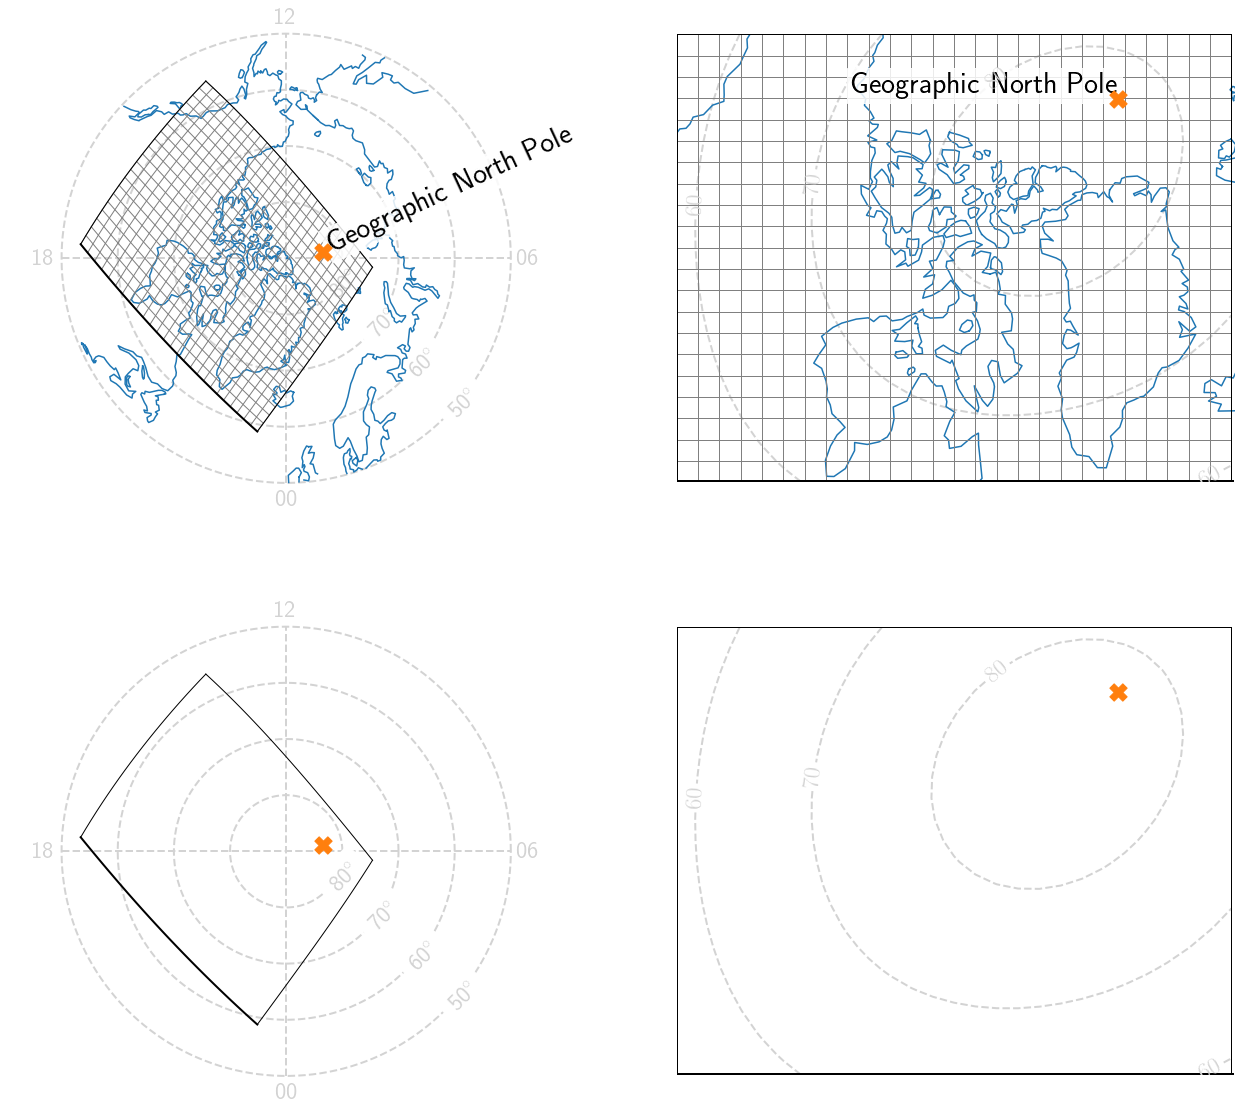

In [5]:
# on polar axis
a = apexpy.Apex(time, refh=0)               # to MLAT/MLT
mlat, mlon = a.geo2apex(90, 0, height = 0)
mlt = a.mlon2mlt(mlon, time)
bboxdict = {'facecolor':'white', 'alpha':.85, 'edgecolor':'white'}
scatdict = {'s':300, 'color':'C1', 'zorder':4, 'marker':'X'}  # 
pax.text(  mlat, mlt, 'Geographic North Pole', fontsize=30, rotation=25, bbox=bboxdict)   # like plt.text
pax .scatter(mlat, mlt, **scatdict)                                                       # like plt.scatter
pax2.scatter(mlat, mlt, **scatdict)

# on grid axis
xi, eta = grid.projection.geo2cube(0,90) # lon, lat, North pole
axs['grid' ].text(   xi, eta, 'Geographic North Pole', fontsize=30, ha='right', va='bottom', bbox=bboxdict)
axs['grid' ].scatter(xi, eta, **scatdict)
axs['grid2'].scatter(xi, eta, **scatdict)

fig

In [6]:
# TODO: terminator
#pax.plot_terminator(time, terminatorcolor='grey', shadecolor='grey')

#fig

#### Contour

As an example of contour plots, we illustrate the electric potential contours from the [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model (also shown in notebooks 01 and 02):

In [7]:
# get Weimer potential
weimer = pd.read_table('./datasets/weimer.txt', sep=' ', skipinitialspace=True, comment='#', 
                       names=['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 50]                    # remove southern hemisphere
mlat   = weimer.mlat.values.reshape((181, 61))       # mlat
mlt    = weimer.mlt .values.reshape((181, 61))       # mlt
V      = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V, at around 110 km

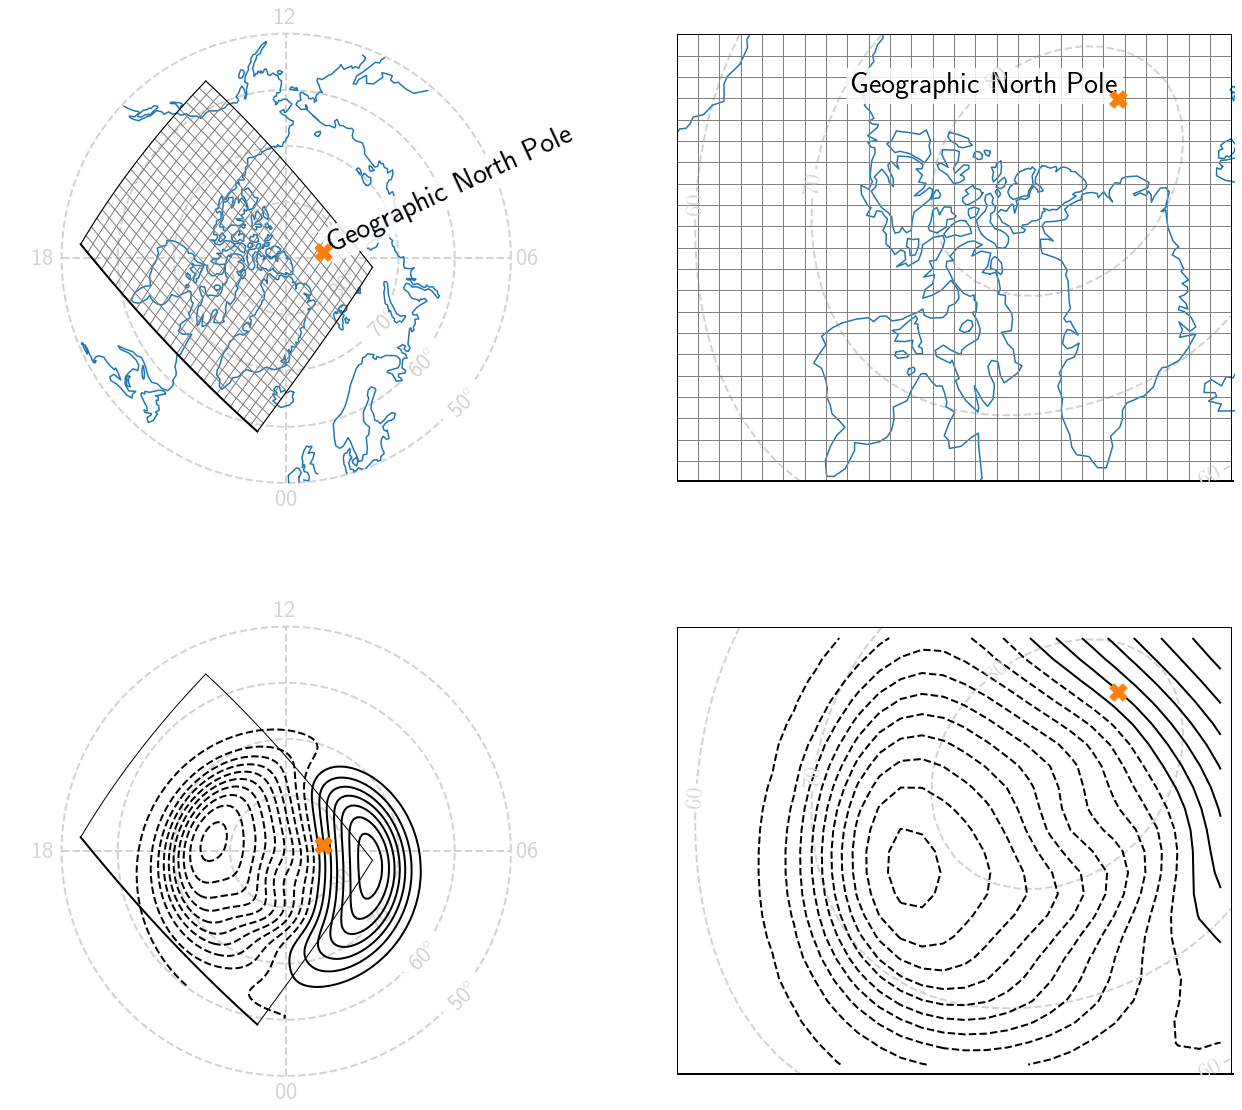

In [8]:
contkwargs = {'levels':np.r_[-101:101:4]*1e3, 'colors':'black', 'linewidths':2, 'zorder':2}
# on polar axis
pax2.contour(mlat, mlt, V, **contkwargs)  # like plt.contour

# on grid axis
mlon = apex.mlt2mlon(mlt, time)    # to geographic coordinates
lat, lon, _ = a.apex2geo(mlat, mlon, height=110)

# interpolate potential to CS grid 
xi, eta = grid.projection.geo2cube(lon, lat) # to cube coordinates
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), 
                   fill_value = 0, method = 'cubic').reshape(grid.shape)
axs['grid2'].contour(grid.xi, grid.eta, V, **contkwargs)

fig

#### Quiver

Vector fields or individual vectors can be plotted using quiver. An example of this is plotting the $\mathbf{E}\times\mathbf{B}$ convection velocity. In Notebook 01, the electric field $\mathbf{E}$ described by the Weimer potential was found using ($\mathbf{E}=-\nabla\Phi$) 
The $\mathbf{E}\times\mathbf{B}$ convection velocity calculated through:
\begin{equation}
    \mathbf{v}_{\perp} = \frac{\mathbf{E}\times\mathbf{B}}{|\mathbf{B}|^2}
\end{equation}
where $\mathbf{B}$ is the geomagnetic field. Here, we assume a dipole magnetic field. We use the same approach to this as we did in notebook 02.

In [9]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = 1, return_sparse = True)
E_e = -De.dot(V.flatten()).reshape(grid.shape)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)

E_n[grid.lat < 60] = 0

# calculate dipole magnetic field radial components and absolute values
B_r = -2 * B0 * np.sin(grid.lat * np.pi / 180) 
B   =      B0 * np.sqrt(1 + 3 * np.sin(grid.lat * np.pi / 180)**2)

# calulate velocity components 
v_e =  E_n * B_r/B**2
v_n = -E_e * B_r/B**2

We now have the geographic east, north components of the $\mathbf{E}\times\mathbf{B}$ convection velocity. Note that the polplot axis requires vector input in *magnetic* east, north, and that the grid axis requires vector input in $\xi, \eta$.

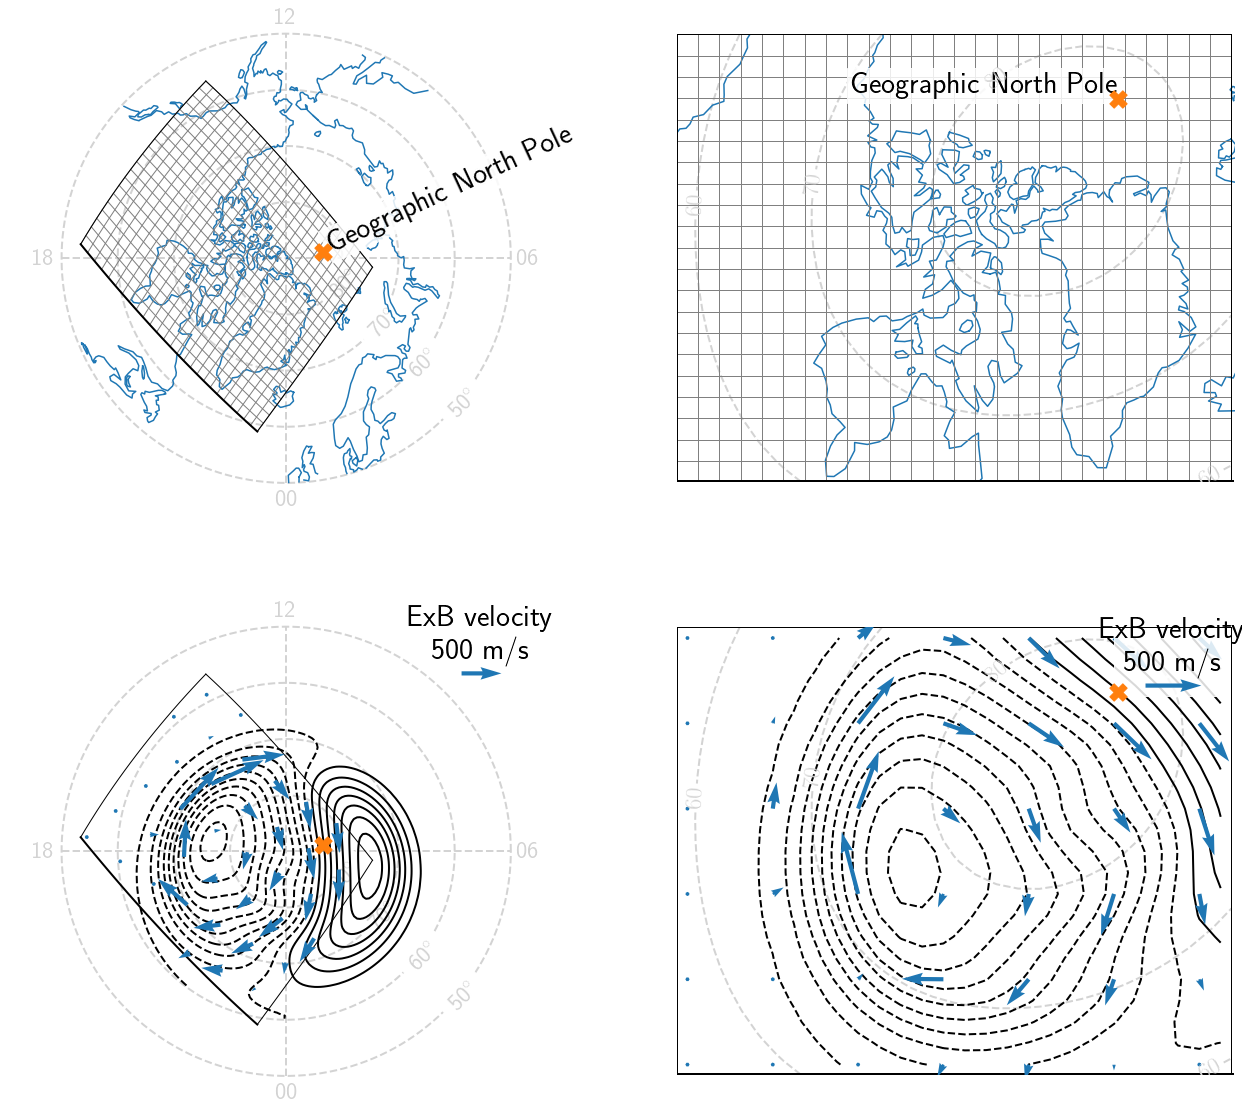

In [10]:
# on polar axis
mlat, mlon = apex.geo2apex(grid.lat, grid.lon, HI*1e-3)        # to MLAT/MLT coordinates
mlt = apex.mlon2mlt(mlon, time)

# rotate vectors to magnetic
f1, f2 = apex.basevectors_qd(grid.lat.flatten(), grid.lon.flatten(), HI*1e-3, coords = 'geo') # Quasi-Dipole eastward, northward
v_geo = np.vstack((v_e.flatten(), v_n.flatten()))
v_emag = np.einsum('ij,ij->j',f1, v_geo) # Richmond (1995) equations (7.12) and (7.13) but for velocity vector
v_nmag = np.einsum('ij,ij->j',f2, v_geo) 

qkey = {'X':.85, 'Y':.86, 'U':500, 'label':"ExB velocity\n 500 m/s", 'labelpos':'N', 
        'fontproperties':{'size':30}, 'zorder':3} # quiver key properties
SKIP = 15
pax2.quiver(mlat.flatten()[::SKIP], mlt.flatten()[::SKIP], v_nmag[::SKIP], v_emag[::SKIP], qkeyproperties=qkey, scale=7000, color='C0', zorder=2) # like plt.quiver

# on grid axis
vxi, veta = grid.projection.vector_cube_projection(v_e.flatten(), v_n.flatten(), 
                                                   grid.lon.flatten(), grid.lat.flatten(), return_xi_eta=False)
vxi, veta = vxi.reshape(grid.shape), veta.reshape(grid.shape)
SKIP = 4
quiv = axs['grid2'].quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], 
                           veta[::SKIP, ::SKIP], scale = 5000, color = 'C0', zorder=3)
gridqkwargs = {'X':.89, 'Y':.87}
qkey.update(gridqkwargs)
axs['grid2'].quiverkey(quiv, **qkey)
axs['grid2'].fill_between([.22,.38], [.22], [.315], edgecolor='face', color='white', zorder=3, alpha=.85)

fig

#### Save plot

Finally, we do small adjustments to the plot and save it.

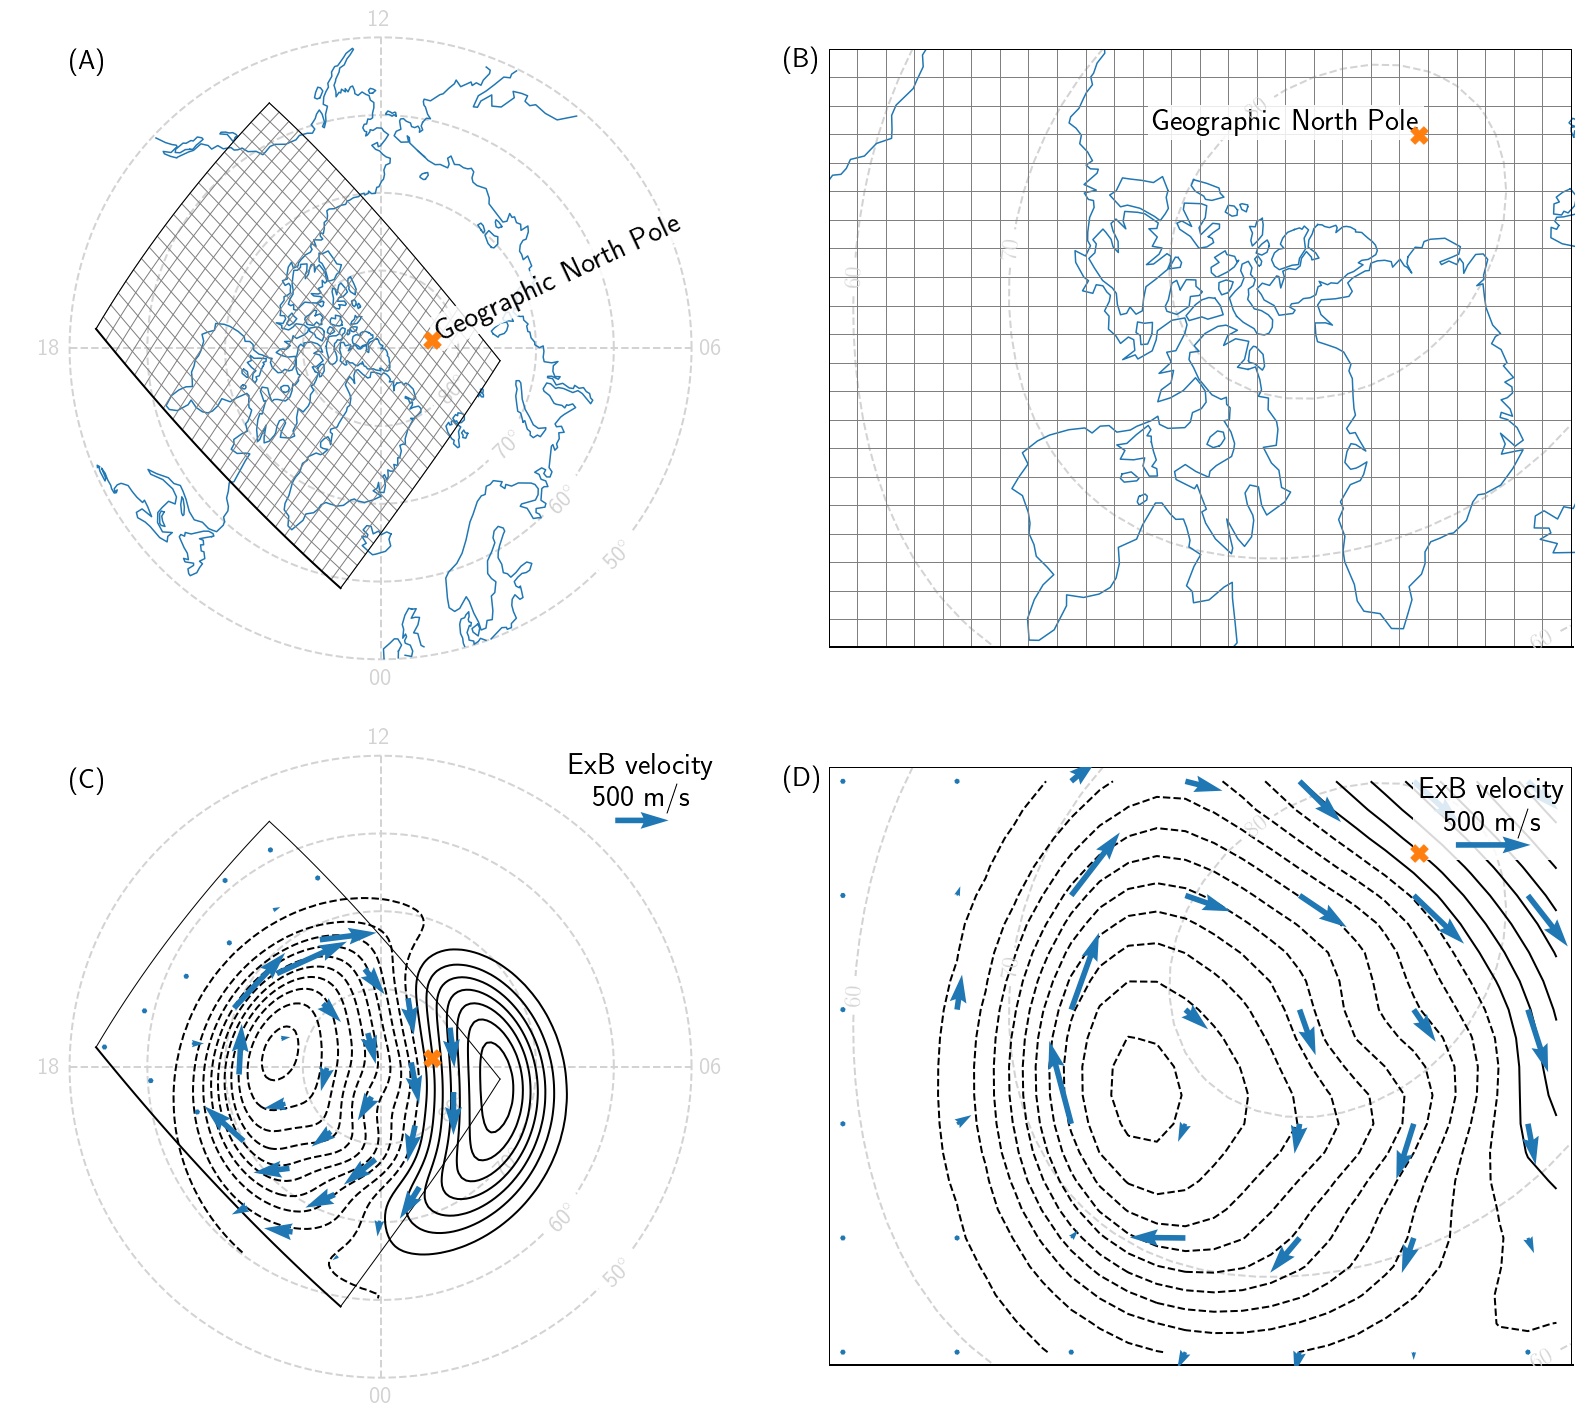

In [11]:
# add subfigure letters
axs['polar' ].text(-1,    0.9, '(A)', fontsize=28)
axs['grid'  ].text(-0.46, 0.3, '(B)', fontsize=28)
axs['polar2'].text(-1,    0.9, '(C)', fontsize=28)
axs['grid2' ].text(-0.46, 0.3, '(D)', fontsize=28)

fig.subplots_adjust(hspace=0.05, wspace=.1, left=0, right=.99, bottom=.016, top=.99)

# save figure
fig.savefig('./output_figures/Polarplotexample.png')
fig.savefig('./output_figures/Polarplotexample.pdf')
fig

The panels show:
- (A) A cubed sphere grid on a MLAT/MLT axis. The thick line corresponds to the bottom of the grid to the right. The orange cross marks the Geographic North Pole.
- (B) The cubed sphere grid as plotted in (A). The same parameters are shown, but in the cubed sphere $\xi, \eta$ coordinate system.
- (C) Same axis as in (A), but without coastlines. The orange cross still marks the Geographic North Pole. Electric potential contours from the Weimer (2005) model is shown in black. The blue arrows show the corotation velocity of the Earth as it rotates below the magnetic latitude/MLT axis.
- (D) The same parameters as in (C), but in cubed sphere $\xi, \eta$ coordinates.
   
    